In [1]:
! apt-get install -y libsm6 libxext6 libxrender-dev
! pip install opencv-python
! pip install --upgrade git+https://github.com/divamgupta/image-segmentation-keras
! pip install segmentation-models

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the newest version (2:1.2.2-1).
libxext6 is already the newest version (2:1.3.3-1).
libxrender-dev is already the newest version (1:0.9.10-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Cloning https://github.com/divamgupta/image-segmentation-keras to /tmp/pip-req-build-1mvxm1jk
  Running command git clone -q https://github.com/divamgupta/image-segmentation-keras /tmp/pip-req-build-1mvxm1jk
Found GPU at: /device:GPU:0


In [17]:
#The imports we will all need
from matplotlib import pyplot as plt 
from PIL import Image, ImageOps
import os
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score
import glob
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
import cv2
import segmentation_models as sm
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.python.keras.utils import conv_utils


#You may have to remove this import and all the @njit wrappers at the top of each function
#I don't think numba works with collab is why
#If it does, keep it. The preproccessing code will run faster if the wrappers are present
#The preprocessing code will take a bit to run without it... I brute forced everything :/
from numba import njit

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

class BilinearUpsampling(Layer):

    def __init__(self, upsampling=(2, 2), data_format=None, **kwargs):
        super(BilinearUpsampling, self).__init__(**kwargs)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        height = self.upsampling[0] * \
                 input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0], height, width, input_shape[3])

    def call(self, inputs):
        # .tf
        return tf.image.resize(inputs, (int(inputs.shape[1] * self.upsampling[0]),
                                                 int(inputs.shape[2] * self.upsampling[1])))

    def get_config(self):

        config = {'size': self.upsampling, 'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def xception_downsample_block(x, channels, top_relu=False):
    ##separable conv1
    if top_relu:
        x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    ##separable conv2
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    ##separable conv3
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def res_xception_downsample_block(x, channels):
    res = Conv2D(channels, (1, 1), strides=(2, 2), padding="same", use_bias=False)(x)
    res = BatchNormalization()(res)
    x = xception_downsample_block(x, channels)
    x = add([x, res])
    return x


def xception_block(x, channels):
    ##separable conv1
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    ##separable conv2
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)

    ##separable conv3
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(channels, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def res_xception_block(x, channels):
    res = x
    x = xception_block(x, channels)
    x = add([x, res])
    return x


def aspp(x, input_shape, out_stride):
    b0 = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    b0 = BatchNormalization()(b0)
    b0 = Activation("relu")(b0)

    b1 = DepthwiseConv2D((3, 3), dilation_rate=(6, 6), padding="same", use_bias=False)(x)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)
    b1 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b1)
    b1 = BatchNormalization()(b1)
    b1 = Activation("relu")(b1)

    b2 = DepthwiseConv2D((3, 3), dilation_rate=(12, 12), padding="same", use_bias=False)(x)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)
    b2 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b2)
    b2 = BatchNormalization()(b2)
    b2 = Activation("relu")(b2)

    b3 = DepthwiseConv2D((3, 3), dilation_rate=(12, 12), padding="same", use_bias=False)(x)
    b3 = BatchNormalization()(b3)
    b3 = Activation("relu")(b3)
    b3 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b3)
    b3 = BatchNormalization()(b3)
    b3 = Activation("relu")(b3)

    out_shape = int(input_shape[0] / out_stride)
    b4 = AveragePooling2D(pool_size=(out_shape, out_shape))(x)
    b4 = Conv2D(256, (1, 1), padding="same", use_bias=False)(b4)
    b4 = BatchNormalization()(b4)
    b4 = Activation("relu")(b4)
    b4 = BilinearUpsampling((out_shape, out_shape))(b4)

    x = Concatenate()([b4, b0, b1, b2, b3])
    return x


def DeeplabV3_plus(nClasses=2, input_height=128, input_width=128, out_stride=16):
    img_input = Input(shape=(input_height, input_width, 1))
    x = Conv2D(32, (3, 3), strides=(2, 2), padding="same", use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = res_xception_downsample_block(x, 128)

    res = Conv2D(256, (1, 1), strides=(2, 2), padding="same", use_bias=False)(x)
    res = BatchNormalization()(res)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    skip = BatchNormalization()(x)
    x = Activation("relu")(skip)
    x = DepthwiseConv2D((3, 3), strides=(2, 2), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x, res])

    x = xception_downsample_block(x, 728, top_relu=True)

    for i in range(16):
        x = res_xception_block(x, 728)

    res = Conv2D(1024, (1, 1), padding="same", use_bias=False)(x)
    res = BatchNormalization()(res)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(728, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = add([x, res])

    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1536, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(1536, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Conv2D(2048, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # aspp
    x = aspp(x, (input_height, input_width, 3), out_stride)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.9)(x)

    ##decoder
    x = BilinearUpsampling((4, 4))(x)
    dec_skip = Conv2D(48, (1, 1), padding="same", use_bias=False)(skip)
    dec_skip = BatchNormalization()(dec_skip)
    dec_skip = Activation("relu")(dec_skip)
    x = Concatenate()([x, dec_skip])

    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = DepthwiseConv2D((3, 3), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, (1, 1), padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(nClasses, (1, 1), padding="same")(x)
    x = BilinearUpsampling((4, 4))(x)
    x = Activation('softmax')(x)
    model = Model(inputs=img_input, outputs=x)
    return model

In [61]:
#The original size of the images, leave as is
OG_SIZE = (1000, 1000)

#The size of image that will be put into the NN
NEW_SIZE = (1024, 1024)

#Resizing flag. If true resizing will be used to make input of size NEW_SIZE
#If false, padding is added on the left and bottom sides of image to make input of size NEW_SIZE
#if using padding, you can only increase dims of OG_SIZE.
RESIZE = True

#The interpolation method for when you want to resize (.tiff and np.arrays will only work with INTER_NEAREST)
interp = cv2.INTER_NEAREST

#How many times to split up the image for the NN
#Only need to use this if having memory troubles
#Will turn 1 (1024,1024) image into 4 (512,512) images for DIV = 2 (or 16 (256,256) for DIV=4 and so on)
DIV = 1


#Scales all input images between 0 and 1
def Scale(arr):
    arr = (arr-np.min(arr))/(np.max(arr)-np.min(arr))
    return arr


#Reserve the space for all inputs and outputs
train_imgs = np.zeros((26,NEW_SIZE[0],NEW_SIZE[1]))
valid_imgs = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))
test_imgs = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))
ross_imgs = np.zeros((1,NEW_SIZE[0],NEW_SIZE[1]))

train_masks = np.zeros((26,NEW_SIZE[0],NEW_SIZE[1]))
valid_masks = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))
test_masks = np.zeros((6,NEW_SIZE[0],NEW_SIZE[1]))



tr = 0
va = 0
te = 0

path = '/content/drive/MyDrive/Images/'

#Goes into Images folder in same folder as this .ipynb and extracts neccesary data
#Make sure you have this folder downloaded the same way as the GitHub 'Images' folder I posted
for folder in os.listdir(path):
    for image in sorted(glob.glob(path + folder + '/*.tif')):
        identifier = image[len(image)-8:len(image)-4]
            
        img = Image.open(image)
            
        if folder == 'data_trainset':
            if identifier == 'mask':
                if RESIZE:
                    train_masks[tr,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                    tr += 1
                else:
                    train_masks[tr,0:OG_SIZE[0],0:OG_SIZE[1]] = np.asarray(img)/255
                    tr += 1
            else:
                if RESIZE:
                    train_imgs[tr,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(Scale(np.asarray(img)), NEW_SIZE, interpolation = interp)
                else:
                    train_imgs[tr,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))
                    
                    
        elif folder == 'data_validset':
            if identifier == 'mask':
                if RESIZE:
                    valid_masks[va,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                    va += 1
                else:
                    valid_masks[va,0:OG_SIZE[0],0:OG_SIZE[1]] = np.asarray(img)/255
                    va += 1
            else:
                if RESIZE:
                    valid_imgs[va,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(Scale(np.asarray(img)), NEW_SIZE, interpolation = interp)
                else:
                    valid_imgs[va,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))
                
                
        elif folder == 'data_testset':
            if identifier == 'mask':
                if RESIZE:
                    test_masks[te,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                    te += 1
                else:
                    test_masks[te,0:OG_SIZE[0],0:OG_SIZE[1]] = np.asarray(img)/255
                    te += 1
            else:
                if RESIZE:
                    test_imgs[te,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(Scale(np.asarray(img)), NEW_SIZE, interpolation = interp)
                else:
                    test_imgs[te,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))

        elif folder == 'data_ross':
            if image == '/content/drive/MyDrive/Images/data_ross/frac_ross.tif':
                if RESIZE:
                    ross_imgs[0,0:NEW_SIZE[0],0:NEW_SIZE[1]] = cv2.resize(np.asarray(img)/255, NEW_SIZE, interpolation = interp)
                else:
                    ross_imgs[0,0:OG_SIZE[0],0:OG_SIZE[1]] = Scale(np.asarray(img))
                


In [64]:
#Only really needed if memory problems,
#Keep in code tho
#If DIV is set to 1 it will work how you guys need it
@njit
def ReshapeX(arr, div):
    out = np.zeros((int((div**2)*arr.shape[0]), int(arr.shape[1]/div), int(arr.shape[2]/div)))
    oc = 0
    for img in arr:
        for d1 in range(div):
            for d2 in range(div):
                out[oc,:,:] = img[d1*int(arr.shape[1]/div):(d1+1)*int(arr.shape[1]/div), d2*int(arr.shape[2]/div):(d2+1)*int(arr.shape[2]/div)]
                oc += 1
    return out

X_train = ReshapeX(train_imgs, DIV)
X_valid = ReshapeX(valid_imgs, DIV)
X_test = ReshapeX(test_imgs, DIV)
X_ross = ReshapeX(ross_imgs, DIV)


#Adds an extra dimension, neccesary for keras formatting
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_ross = X_ross.reshape(X_ross.shape[0],X_ross.shape[1],X_ross.shape[2],1)

#puts Y data into 1 hot encoded formatting for keras
@njit
def OHE(arr, div):
    out = np.zeros((int((div**2)*arr.shape[0]), int(arr.shape[1]/div), int(arr.shape[2]/div), 2, 1))
    
    oc = 0
    for img in arr:
        for d1 in range(div):
            for d2 in range(div):
                pc = 0
                ic = 0
                for i in range(d1*int(arr.shape[1]/div),(d1+1)*int(arr.shape[1]/div)):
                    jc = 0
                    for j in range(d2*int(arr.shape[2]/div),(d2+1)*int(arr.shape[2]/div)):
                        value = img[i,j]
                        if int(value) == 0:
                            out[oc,ic,jc,:] = np.array([[1], [0]]) #No fracture
                        if int(value) == 1:
                            out[oc,ic,jc,:] = np.array([[0], [1]]) #Fracture
                        pc += 1
                        jc += 1
                    ic += 1
                oc += 1
    return out

Y_train = OHE(train_masks,DIV)
Y_valid = OHE(valid_masks,DIV)
Y_test = OHE(test_masks,DIV)


#Adds weight to samples for loss funtion
#since there are so few fracture pixels compared to no fracture
#it helps to add additional weight in our loss function to the fracture class
#Right now fractures are weighted 3x as much as no fracture
#If you don't wanna use it, dont pass it through your fit funtion
@njit
def SampleWeight(arr):
    ws = np.ones((arr.shape[0],arr.shape[1],arr.shape[2]))
    for b, block in enumerate(arr):
        for i, ival in enumerate(block):
            for j, jval in enumerate(ival):
                if jval[0,0] == 0:
                    ws[b,i,j] = 4 #Change this number to set the fracture weight
    return ws

sample_weight_train = SampleWeight(Y_train)
sample_weight_valid = SampleWeight(Y_valid)

In [50]:
#Instantiate the model, compile the model, and train the model
#several parameters of this step will need customization depending of the model

#Take note of the input_shape... you will need that
#model = Deeplabv3(weights = None, input_shape = (int(NEW_SIZE[0]/DIV), int(NEW_SIZE[1]/DIV), 1), classes = 2, backbone='xception', activation='softmax', OS = 8, alpha=1.)
#model = DeeplabV3Plus(image_size=int(NEW_SIZE[0]/DIV), num_classes=2)

model = DeeplabV3_plus(nClasses=2, input_height=int(NEW_SIZE[0]/DIV), input_width=int(NEW_SIZE[1]/DIV), out_stride=16)

loss = tf.keras.losses.BinaryCrossentropy()

#Learning rate was tuned for my specific model
#optimizer = keras.optimizers.Adam(1e-3)
optimizer = Adam(learning_rate=1e-3)
model.compile(loss=loss, optimizer=optimizer, metrics=['categorical_accuracy'])

#Stop training when validation loss is at minimum and restore weights from that epoch
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

#Arbitrarily high epochs to ensure callback is found
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid, sample_weight_valid), epochs=1000, verbose=1, batch_size=2, sample_weight=sample_weight_train, callbacks=[callback])

Epoch 1/1000
13/13 [==============================] - 31s 2s/step - loss: 0.3185 - categorical_accuracy: 0.9730 - val_loss: 0.6121 - val_categorical_accuracy: 0.9946
Epoch 2/1000
13/13 [==============================] - 19s 1s/step - loss: 0.0963 - categorical_accuracy: 0.9930 - val_loss: 0.5097 - val_categorical_accuracy: 0.9946
Epoch 3/1000
13/13 [==============================] - 19s 2s/step - loss: 0.0526 - categorical_accuracy: 0.9934 - val_loss: 0.4268 - val_categorical_accuracy: 0.9946
Epoch 4/1000
13/13 [==============================] - 19s 2s/step - loss: 0.0390 - categorical_accuracy: 0.9935 - val_loss: 0.3535 - val_categorical_accuracy: 0.9946
Epoch 5/1000
13/13 [==============================] - 19s 1s/step - loss: 0.0369 - categorical_accuracy: 0.9930 - val_loss: 0.3029 - val_categorical_accuracy: 0.9946
Epoch 6/1000
13/13 [==============================] - 19s 1s/step - loss: 0.0326 - categorical_accuracy: 0.9935 - val_loss: 0.2567 - val_categorical_accuracy: 0.9946
Epoc

ResourceExhaustedError: ignored

In [65]:
#Undo reshape I used for memory and take argmax of results (Just takes argmax if DIV = 1)
#arg_arg true or false if you want argmax or not, respectively
def preds2imgs(arr, div, arg_arg):
    if arg_arg:
        temp = np.argmax(arr, axis=3)
        out = np.zeros((int((arr.shape[0])/(div**2)),int((arr.shape[1]*div)),int(arr.shape[1]*div)))
    else:
        temp = arr
        out = np.zeros((int((arr.shape[0])/(div**2)),int((arr.shape[1]*div)),int(arr.shape[1]*div),2))
        
    tc = 0
    for img in range(int((arr.shape[0])/(div**2))):
        for d1 in range(div):
            for d2 in range(div):
                if arg_arg:
                    out[img, d1*int(temp.shape[1]):(d1+1)*int(temp.shape[1]), d2*int(temp.shape[1]):(d2+1)*int(temp.shape[1])] = temp[tc]
                    tc += 1
                else:
                    out[img, d1*int(temp.shape[1]):(d1+1)*int(temp.shape[1]), d2*int(temp.shape[1]):(d2+1)*int(temp.shape[1]),:] = temp[tc]
                    tc += 1
    return out


#Show loss and accuracy of all datasets from epoch of restored weights
acc_train = model.evaluate(X_train, Y_train, verbose=0, batch_size=1)
print(" Train loss: ", acc_train[0], " Train accuracy: ", acc_train[1])
acc_valid = model.evaluate(X_valid, Y_valid, verbose=0, batch_size=1)
print(" Valid loss: ", acc_valid[0], " Valid accuracy: ", acc_valid[1])
acc_test = model.evaluate(X_test, Y_test, verbose=0, batch_size=1)
print(" Test loss: ", acc_test[0], " Test accuracy: ", acc_test[1])

#predict your results
valid_results = model.predict(X_valid, batch_size=1)
test_results = model.predict(X_test, batch_size=1)
ross_results = model.predict(X_ross, batch_size=1)

valid_argmax_pred = preds2imgs(valid_results, DIV, True)
valid_argmax_true = preds2imgs(np.squeeze(Y_valid, axis = 4), DIV, True)

test_argmax_pred = preds2imgs(test_results, DIV, True)
test_argmax_true = preds2imgs(np.squeeze(Y_test, axis = 4), DIV, True)

# #Plot accuracies from training
# plt.plot(history.history['categorical_accuracy'])
# plt.plot(history.history['val_categorical_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# #Plot losses from training
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


#Resizes or removes padding from argmax results depending on which you used.
def ToOGSize(arr, num_images, RESIZE, OG_SIZE, interp):
    OG = np.zeros((num_images,OG_SIZE[0],OG_SIZE[1]))
    for i in range(num_images):
        if RESIZE:
            OG[i,:,:] = cv2.resize(arr[i], OG_SIZE, interpolation=interp)
        else:
            OG[i,:,:] = arr[i,0:OG_SIZE[0],0:OG_SIZE[1]]
    return OG

valid_argmax_pred_OG = ToOGSize(valid_argmax_pred,
                                6, RESIZE,
                                OG_SIZE, interp)
valid_argmax_true_OG = ToOGSize(valid_argmax_true,
                                6, RESIZE,
                                OG_SIZE, interp)

test_argmax_pred_OG = ToOGSize(test_argmax_pred,
                               6, RESIZE,
                               OG_SIZE, interp)

test_argmax_true_OG = ToOGSize(test_argmax_true,
                               6, RESIZE,
                               OG_SIZE, interp)

 Train loss:  0.01696721650660038  Train accuracy:  0.994746744632721
 Valid loss:  0.023261658847332  Valid accuracy:  0.9941315650939941
 Test loss:  0.042166274040937424  Test accuracy:  0.9889121055603027


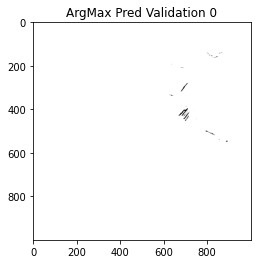

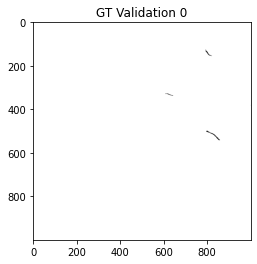

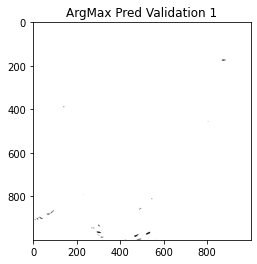

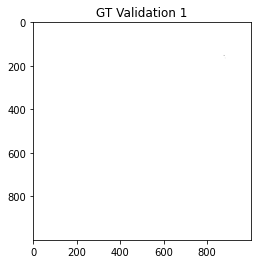

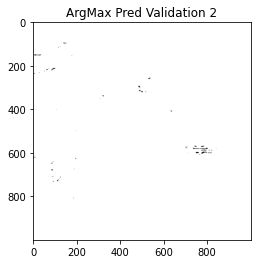

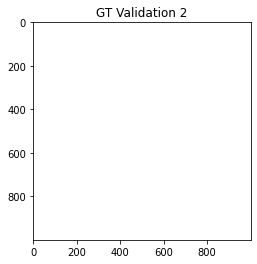

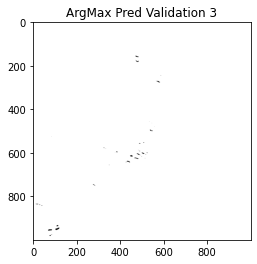

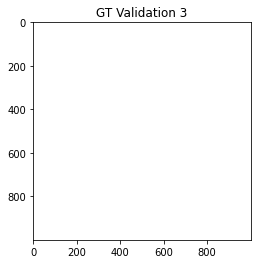

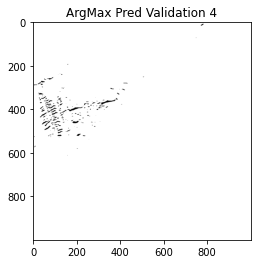

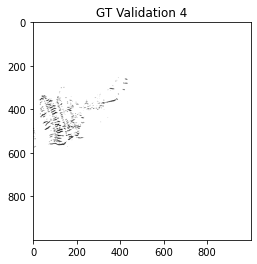

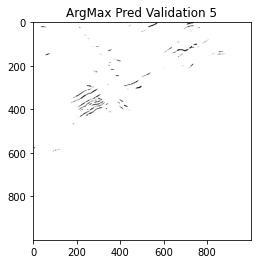

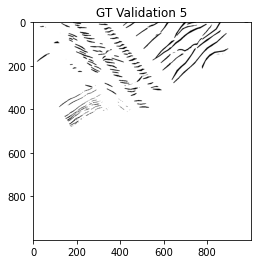

In [66]:
#Plot argmax results for validation data and GT
for i, pred in enumerate(valid_argmax_pred_OG):
    plt.imshow(pred,cmap='binary')
    plt.title("ArgMax Pred Validation "+ str(i))
    plt.show()
    plt.imshow(valid_argmax_true_OG[i], cmap='binary')
    plt.title("GT Validation "+ str(i))
    plt.show()

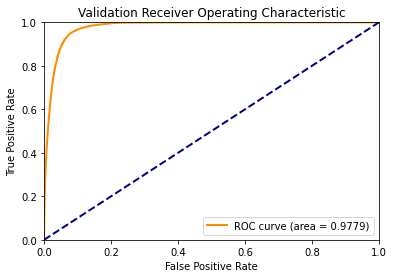

AUC =  0.9779149806874079


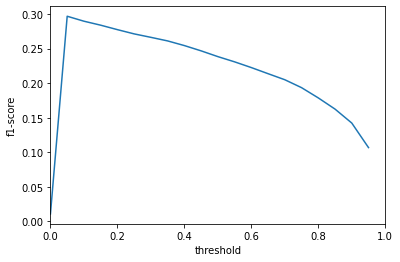

In [67]:
#Formats the data as neccesary to use sklearn roc_curve function
def ToROC(arr, arr_pred):
    out = np.zeros(int(arr.shape[0]*arr.shape[1]*arr.shape[2]))
    out_pred = np.zeros(int(arr.shape[0]*arr.shape[1]*arr.shape[2]))
    c = 0
    for b, block in enumerate(arr):
        for i, ival in enumerate(block):
            for j, jval in enumerate(ival):
                if jval[1] == 1:
                    out[c] = 1
                
                out_pred[c] = arr_pred[b,i,j,1]
                c += 1
    return out, out_pred

temp_Y_valid_OG = Y_valid.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2,1)
Y_valid_OG = np.zeros((6,OG_SIZE[0],OG_SIZE[0],2,1))

temp_valid_results_OG = valid_results.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2)
valid_results_OG = np.zeros((6,OG_SIZE[0],OG_SIZE[0],2,1))

if RESIZE:
    for i in range(6):
        temp_OG_0 = cv2.resize(temp_Y_valid_OG[i,:,:,0,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_Y_valid_OG[i,:,:,1,0], OG_SIZE, interpolation=interp)
        Y_valid_OG[i,:,:,0,0] = temp_OG_0
        Y_valid_OG[i,:,:,1,0] = temp_OG_1
        
        temp_OG_0 = cv2.resize(temp_valid_results_OG[i,:,:,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_valid_results_OG[i,:,:,1], OG_SIZE, interpolation=interp)
        
        valid_results_OG[i,:,:,0] = np.expand_dims(temp_OG_0, axis = 2)
        valid_results_OG[i,:,:,1] = np.expand_dims(temp_OG_1, axis = 2)
else:
    Y_valid_OG = temp_Y_valid_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:,:]
    valid_results_OG = temp_valid_results_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:]

#Generates the ROC curve and solves the AUC
valid_roc_true, valid_roc_pred = ToROC(np.squeeze(Y_valid_OG, axis=4), valid_results_OG)
fpr, tpr, thresholds = roc_curve(valid_roc_true, valid_roc_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

#Plot ROC curve and print AUC score
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('AUC = ',roc_auc)


#Determine the fracture threshold best suitable for maximizing f1-score based on validation data
f1 = []
spacing = 0.05
thr = np.arange(0,1,spacing)
for i in thr:
    f1.append(f1_score(valid_roc_true, (valid_roc_pred > i)))

#saves value of best threshold
threshold = np.argmax(f1)*spacing

#Plots the f1-score as a function of threshold values
plt.figure()
plt.plot(thr, f1)
plt.xlim([0,1])
plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.show()

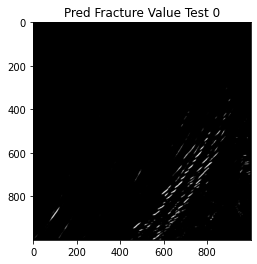

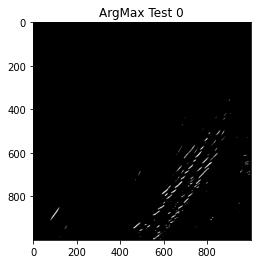

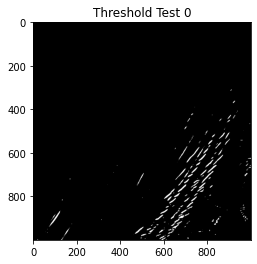

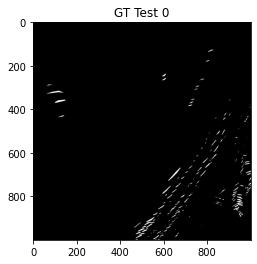

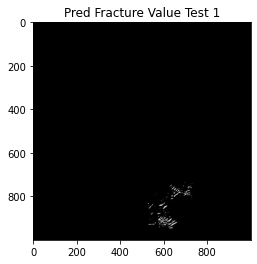

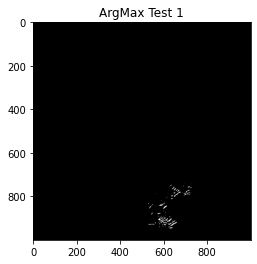

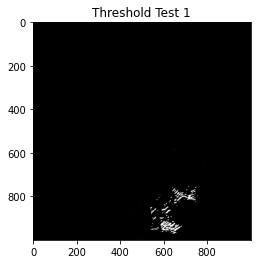

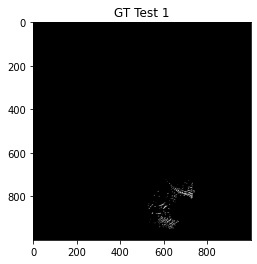

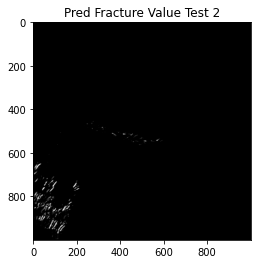

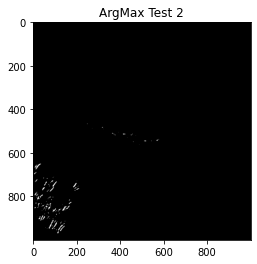

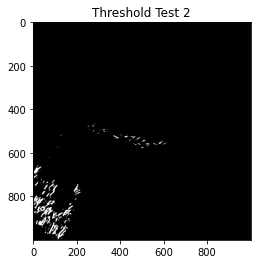

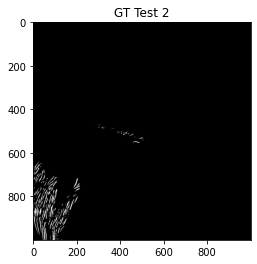

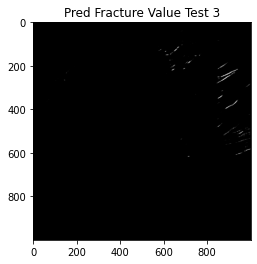

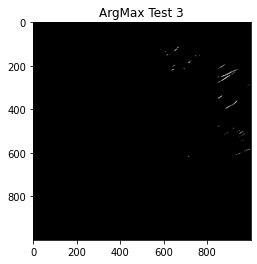

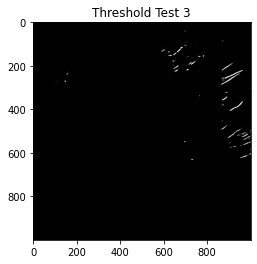

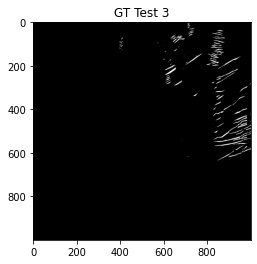

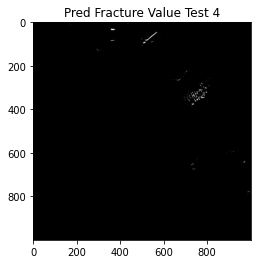

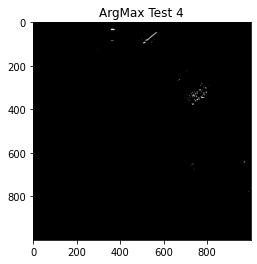

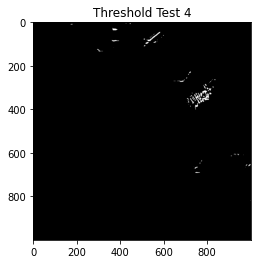

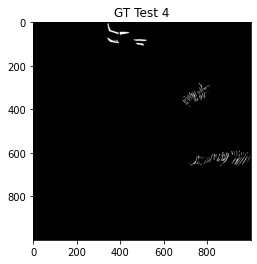

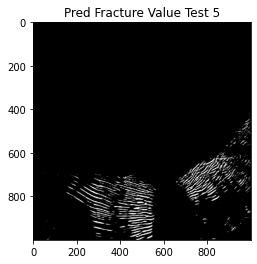

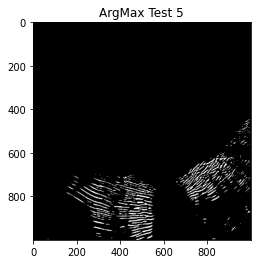

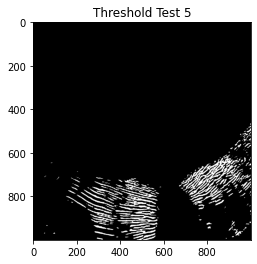

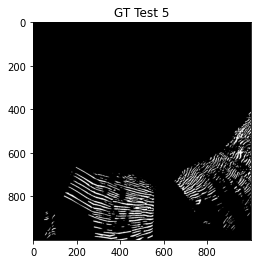

Threshold Test F1-score =  0.5066317952549972


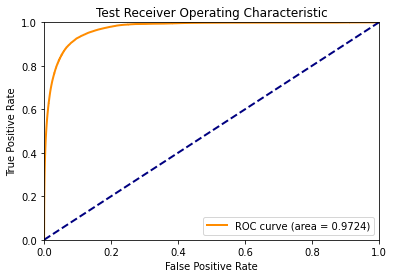

Raw Preds Test AUC =  0.9724170331618189


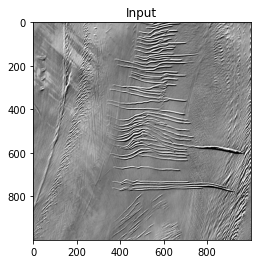

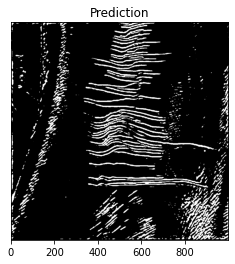

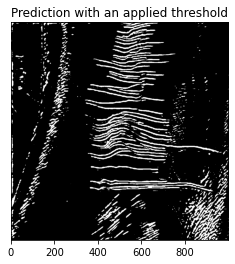

In [73]:
#Applies threshold found previously to test results

def ApplyThreshold(arr, thr):
    out = np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
    for b, block in enumerate(arr):
        for i, ival in enumerate(block):
            for j, jval in enumerate(ival):
                if jval[1] >= thr:
                    out[b,i,j] = 1
    return out

test_pred_thr = ApplyThreshold(preds2imgs(test_results, DIV, False), threshold)
ross_pred_thr = ApplyThreshold(preds2imgs(ross_results, DIV, False), threshold)

#Reshapes raw test probability results as neccesary for plotting.
temp_Y_test_OG = Y_test.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2,1)
Y_test_OG = np.zeros((6,OG_SIZE[0],OG_SIZE[0],2,1))

temp_test_results_OG = test_results.reshape(6,NEW_SIZE[0],NEW_SIZE[0],2)
test_results_OG = np.zeros((6,OG_SIZE[0],OG_SIZE[0],2,1))

temp_ross_results_OG = ross_results.reshape(1,NEW_SIZE[0],NEW_SIZE[0],2)
ross_results_OG = np.zeros((1,OG_SIZE[0],OG_SIZE[0],2,1))

if RESIZE:
    for i in range(6):
        temp_OG_0 = cv2.resize(temp_Y_test_OG[i,:,:,0,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_Y_test_OG[i,:,:,1,0], OG_SIZE, interpolation=interp)
        Y_test_OG[i,:,:,0,0] = temp_OG_0
        Y_test_OG[i,:,:,1,0] = temp_OG_1
        
        temp_OG_0 = cv2.resize(temp_test_results_OG[i,:,:,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_test_results_OG[i,:,:,1], OG_SIZE, interpolation=interp)
        test_results_OG[i,:,:,0] = np.expand_dims(temp_OG_0, axis = 2)
        test_results_OG[i,:,:,1] = np.expand_dims(temp_OG_1, axis = 2)

        temp_OG_0 = cv2.resize(temp_ross_results_OG[0,:,:,0], OG_SIZE, interpolation=interp)
        temp_OG_1 = cv2.resize(temp_ross_results_OG[0,:,:,1], OG_SIZE, interpolation=interp)
        ross_results_OG[0,:,:,0] = np.expand_dims(temp_OG_0, axis = 2)
        ross_results_OG[0,:,:,1] = np.expand_dims(temp_OG_1, axis = 2)
else:
    Y_test_OG = temp_Y_test_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:,:]
    test_results_OG = temp_test_results_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:]
    ross_results_OG = temp_ross_results_OG[:,0:OG_SIZE[0],0:OG_SIZE[1],:]
        
#Plot the raw output of fractures, the ArgMax results, the Threshold applied results, and the Ground truths
for i in range(6):
    plt.imshow(test_results_OG[i,:,:,1].reshape((test_results_OG.shape[1], test_results_OG.shape[2])),cmap='binary_r') #Show if you use softmax activation
    plt.title("Pred Fracture Value Test "+ str(i))
    plt.show()
    plt.imshow(test_argmax_pred_OG[i],cmap='binary_r')
    plt.title("ArgMax Test "+ str(i))
    plt.show()
    plt.imshow(test_pred_thr[i,0:OG_SIZE[0],0:OG_SIZE[1]],cmap='binary_r')
    plt.title("Threshold Test "+ str(i))
    plt.show()
    plt.imshow(test_argmax_true_OG[i], cmap='binary_r')
    plt.title("GT Test "+ str(i))
    plt.show()


#Solve the ROC curve and AUC for test data
roc_true_Y, roc_pred_Y = ToROC(np.squeeze(Y_test_OG, axis=4), test_results_OG)
# fpr, tpr, thresholds = roc_curve(roc_true_Y, (roc_pred_Y > threshold), pos_label=1)
# roc_auc = auc(fpr, tpr)

# #Plot the ROC curve, print AUC, and print F1-score score for test data
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Test Receiver Operating Characteristic')
# plt.legend(loc = 'lower right')
# plt.show()
# print('Threshold Test AUC = ',roc_auc)
print('Threshold Test F1-score = ', f1_score(roc_true_Y, (roc_pred_Y > threshold)))


# fpr, tpr, thresholds = roc_curve(test_argmax_true_OG.flatten(), test_argmax_pred_OG.flatten(), pos_label=1)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Test Receiver Operating Characteristic')
# plt.legend(loc = 'lower right')
# plt.show()
# print('ArgMax Test AUC = ',roc_auc)
# print('ArgMax Test F1-score = ', f1_score(test_argmax_true_OG.flatten(), test_argmax_pred_OG.flatten()))


fpr, tpr, thresholds = roc_curve(Y_test_OG[:,:,:,1].flatten(), test_results_OG[:,:,:,1].flatten(), pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('Raw Preds Test AUC = ',roc_auc)


plt.imshow(ross_imgs[0,0:OG_SIZE[0],0:OG_SIZE[1]],cmap='binary_r') #Show if you use softmax activation
plt.title('Input')
plt.show()
plt.imshow(ross_results_OG[0,:,:,1].reshape((ross_results_OG.shape[1], test_results_OG.shape[2])),cmap='binary_r') #Show if you use softmax activation
plt.title('Prediction')
plt.yticks([])
plt.show()
plt.imshow(ross_pred_thr[0,0:OG_SIZE[0],0:OG_SIZE[1]],cmap='binary_r')
plt.title('Prediction with an applied threshold')
plt.yticks([])
plt.show()

In [75]:
model.save('/content/drive/MyDrive/DeepLabV3_trained/model1.h5')